<a href="https://colab.research.google.com/github/jetsonmom/fastcampus_yolo/blob/main/6_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model

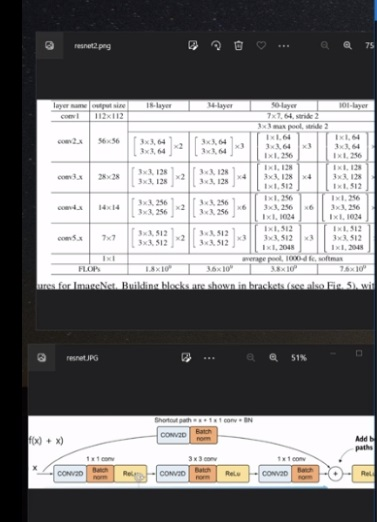

In [2]:
def bottleneck_residual_block(X, middle_conv_filter, conv_filters, stage, block, reduce=False, s=2):
    #     ( conv_filters[0] BN ) > X_shortcut
    # X - ( conv_filters[0] BN ReLU - conv_filters[1] BN ReLU - conv_filters[2] BN ) +  ReLU
    conv_name_base = 'res' + str(stage) + block + '_branch'     # defining name basis
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = conv_filters

    X_shortcut = X
    # if 문은 64를 256으로 연결하기 위한것으로 사진에 있는 것을 보고해야한다
    if reduce:  # reduce
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a')(X)
        X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X) # Channel axis normalization
        X = Activation('relu')(X)

        X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    else:
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
        X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)

    X = Conv2D(filters = F2, kernel_size = (middle_conv_filter, middle_conv_filter), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X    # output of the identity block, tensor of shape (H, W, C)



In [3]:
def ResNet50(input_shape, classes):
    X_input = Input(input_shape)    # Define the input tensor with shape, input_shape

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X_input)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = bottleneck_residual_block(X, 3, [64, 64, 256], stage=2, block='a', reduce=True, s=1)
    X = bottleneck_residual_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = bottleneck_residual_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='a', reduce=True, s=2)
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='a', reduce=True, s=2)
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='a', reduce=True, s=2)
    X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # Average pooling
    X = AveragePooling2D((1,1), name="avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)

    # Create the model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [4]:
model = ResNet50(input_shape = (32,32, 3), classes = 10)
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 13, 13, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 13, 13, 64)           256       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 activation (Activation)     (None, 13, 13, 64)           0         ['bn_conv1[0][0]']     

In [ ]:
import keras
from keras.applications.resnet import ResNet50


In [ ]:
base_model = ResNet50(weights= None, include_top=True, input_shape= (224, 224, 3), classes=10)
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           